In [1]:
import numpy as np
import sys
import os 
import tensorflow_model_optimization as tfmt 
import tensorflow as tf
import seaborn as sns
import random
import zipfile
import matplotlib.pyplot as plt

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.models import  Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras import layers

from PIL import Image
from PIL import UnidentifiedImageError

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

from collections import Counter


In [6]:
with zipfile.ZipFile("/Users/esteb/YOLO/Lenguaje.zip", 'r') as zip:
    zip.extractall("Lenguaje")

In [2]:
dataset_dir = "Lenguaje/Image"

In [3]:
IMG_SIZE = (224,224)
BATCH_SIZE = 32 

#Lista imagenes del archivo extraido 
image_files = []
labels = []
for root, _, files in os.walk(dataset_dir):
    for file in files:
        if file.lower().endswith(('jpeg','jpg','png')):
            image_files.append(os.path.join(root, file))
            labels.append(os.path.basename(root))
        
#Se convierte a tensores (facilidad con tensorflow)
image_files = tf.constant(image_files)
labels = tf.constant(labels)

#Codificar etiquetas para valores int
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels.numpy())

#Convertir etiquetas a tensor
labels = tf.constant(labels)

#Crear dataset de tensorflow 
def parse_function(filename, label):
    img = tf.io.read_file(filename) #lee archivo 
    img = tf.image.decode_jpeg(img, channels=3) #decodifica la imagen
    img = tf.image.resize(img, IMG_SIZE) #redimensiona imagen
    img = img / 255.0 #normalizar los pixeles 0 y 1
    return img, label

dataset = tf.data.Dataset.from_tensor_slices((image_files, labels))
dataset = dataset.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)

print(f"Numero de imagenes cargadas: {len(image_files)}")
print(f"Numero de etiquetas cargas: {len(labels)}")

Numero de imagenes cargadas: 2626
Numero de etiquetas cargas: 2626


In [4]:
#DIVISION DEL DATASET
print("Se divide el dataset en conjuntos de entrenamiento, validacion y prueba")

dataset = dataset.shuffle(len(image_files), reshuffle_each_iteration=False)
dataset_size = tf.data.experimental.cardinality(dataset).numpy()
print(f"Numero total de imagenes del dataset: {dataset_size}")

train_size = int(0.7 * len(image_files))
val_size = int(0.2 * len(image_files))
test_size = dataset_size - train_size - val_size

print(f"Tamaño del conjunto de Entrenamiento: {train_size}")
print(f"Tamaño del conjunto de Validación: {val_size}")
print(f"Tamaño del conjunto de Prueba: {test_size}")

train_dataset = dataset.take(train_size)
val_test_dataset = dataset.skip(train_size)
val_dataset = dataset.take(val_size)
test_dataset = dataset.skip(val_size)

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)


print(f"Tamaño del conjunto de Entrenamiento (número de lotes): {tf.data.experimental.cardinality(train_dataset).numpy()}")
print(f"Tamaño del conjunto de Validación (número de lotes): {tf.data.experimental.cardinality(val_dataset).numpy()}")
print(f"Tamaño del conjunto de Prueba (número de lotes): {tf.data.experimental.cardinality(test_dataset).numpy()}")

Se divide el dataset en conjuntos de entrenamiento, validacion y prueba
Numero total de imagenes del dataset: 2626
Tamaño del conjunto de Entrenamiento: 1838
Tamaño del conjunto de Validación: 525
Tamaño del conjunto de Prueba: 263
Tamaño del conjunto de Entrenamiento (número de lotes): 58
Tamaño del conjunto de Validación (número de lotes): 17
Tamaño del conjunto de Prueba (número de lotes): 66


In [5]:
#ENTRENAMIENTO DEL MODELO
print("Configurar el modelo MOBILENETV2")
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False,input_shape=(224,224,3))

Configurar el modelo MOBILENETV2


In [6]:
#ENTRENAMIENTO POR EPOCAS

base_model.trainable = False

inputs = base_model.input
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(labels), activation='softmax')(x)


model = tf.keras.Model(inputs=inputs, outputs=outputs)

epochs = 10
steps_per_epoch = np.ceil(train_size / BATCH_SIZE)


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
#model.summary()

callbacks = [
    tfmt.sparsity.keras.UpdatePruningStep(),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ]
)

Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 45s 682ms/step - accuracy: 0.0209 - loss: 7.5192 - val_accuracy: 0.0800 - val_loss: 5.5027
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 37s 621ms/step - accuracy: 0.1298 - loss: 4.4406 - val_accuracy: 0.7486 - val_loss: 2.4858
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 40s 667ms/step - accuracy: 0.8140 - loss: 2.2763 - val_accuracy: 0.9524 - val_loss: 1.7418
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 36s 611ms/step - accuracy: 0.9676 - loss: 1.5930 - val_accuracy: 0.9810 - val_loss: 1.1951
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 36s 600ms/step - accuracy: 0.9831 - loss: 1.0892 - val_accuracy: 0.9981 - val_loss: 0.8145
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 36s 600ms/step - accuracy: 0.9972 - loss: 0.7449 - val_accuracy: 1.0000 - val_loss: 0.5624
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 36s 593ms/step - accuracy: 1.0000 - loss: 0.5160 - val_accuracy: 1.0000 - val_loss: 0.3969
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 36s 596ms/step - accuracy: 1.0000 - loss: 0.3683 - val_accu

In [7]:
#Evaluar 
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Precision del conjunto de prueba: {test_accuracy * 100:.2f}")

66/66 ━━━━━━━━━━━━━━━━━━━━ 35s 517ms/step - accuracy: 1.0000 - loss: 0.1699
Precision del conjunto de prueba: 100.00


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

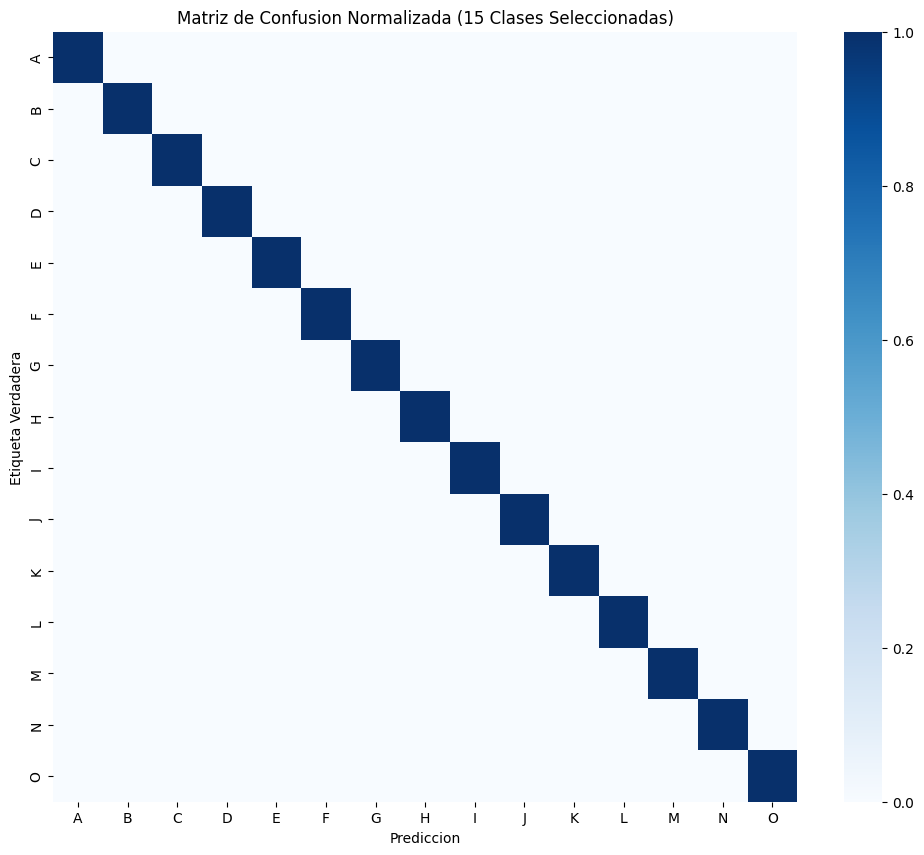

Reporte de Clasificacion para las Clases Seleccionadas:

              precision    recall  f1-score   support

           A       1.00      1.00      1.00        74
           B       1.00      1.00      1.00        78
           C       1.00      1.00      1.00        86
           D       1.00      1.00      1.00        77
           E       1.00      1.00      1.00        77
           F       1.00      1.00      1.00        80
           G       1.00      1.00      1.00        79
           H       1.00      1.00      1.00        87
           I       1.00      1.00      1.00        75
           J       1.00      1.00      1.00        83
           K       1.00      1.00      1.00        78
           L       1.00      1.00      1.00        82
           M       1.00      1.00      1.00        78
           N       1.00      1.00      1.00        91
           O       1.00      1.00      1.00        79

   micro avg       1.00      1.00      1.00      1204
   macro avg       1.00

In [8]:

#Reporte de Clasificacion
y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Obtener los nombres de las clases y decodificarlos si es necesario
class_names = label_encoder.classes_
class_names = [name.decode('utf-8') if isinstance(name, bytes) else name for name in class_names]

#Numero maximo para ver en la confusion
max_classes = 15
clases_mostrar = np.arange(max_classes)

# Obtener los nombres de las clases de la lista
class_names_mostrar = [class_names[i] for i in clases_mostrar]

# Normalizar la matriz de confusion
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Extraer la submatriz para las clases seleccionadas
cm_mostrar = cm_norm[np.ix_(clases_mostrar, clases_mostrar)]

# Visualizar la matriz
plt.figure(figsize=(12, 10))
sns.heatmap(cm_mostrar, annot=False, cmap='Blues', xticklabels=class_names_mostrar, yticklabels=class_names_mostrar)
plt.xlabel('Prediccion')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusion Normalizada (15 Clases Seleccionadas)')
plt.show()

# Generar el reporte
report = classification_report(
    y_true, 
    y_pred, 
    labels=clases_mostrar, 
    target_names=class_names_mostrar
)

print("Reporte de Clasificacion para las Clases Seleccionadas:\n")
print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


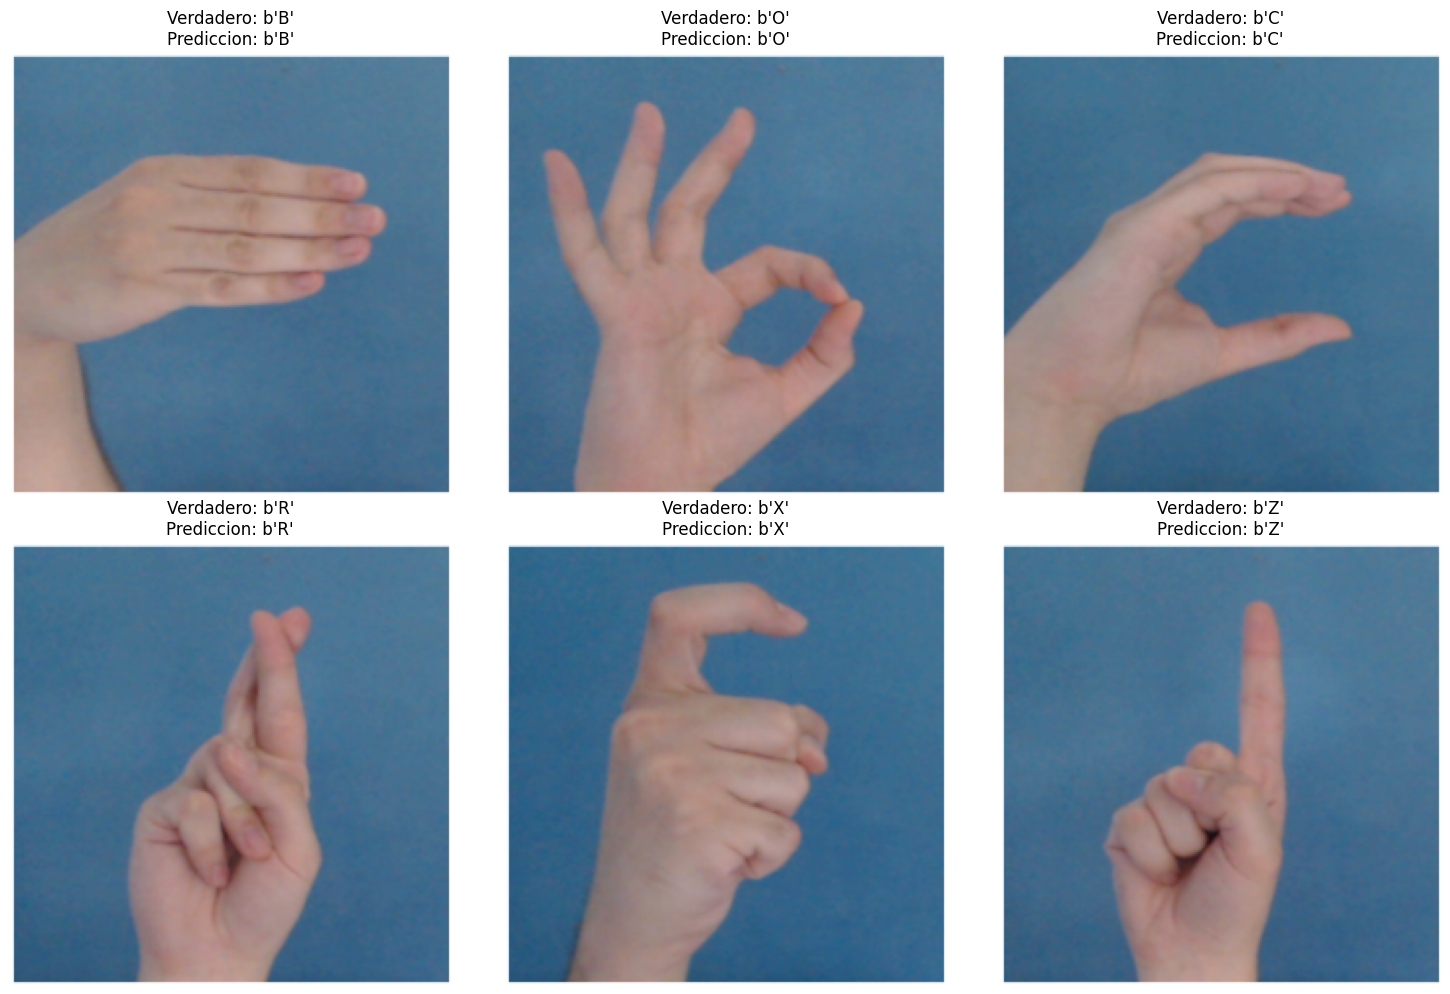

In [9]:
def mostrar_predicciones_en_prueba(dataset, num_images=6):
    dataset_iter = iter(dataset.unbatch().shuffle(1000)) #se itera

    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        image, label = next(dataset_iter) #obtiene imagen y etiqueta
        image_expanded = tf.expand_dims(image, axis=0) #expandir dimesiones
        pred_probs = model.predict(image_expanded) #prediccion
        pred_label = np.argmax(pred_probs, axis=1)[0]

        # Obtener los nombres de las clases
        true_class_name = label_encoder.inverse_transform([label.numpy()])[0]
        pred_class_name = label_encoder.inverse_transform([pred_label])[0]
        plt.subplot(2, 3, i+1)
        plt.imshow(image)
        plt.title(f'Verdadero: {true_class_name}\nPrediccion: {pred_class_name}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
mostrar_predicciones_en_prueba(test_dataset)